In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
import torch_scatter

import numpy as np
from sklearn.metrics import ndcg_score
from collections import defaultdict
import pandas as pd

from pathlib import Path

In [ ]:
project_root = Path("C://Users//DELL//Desktop//the-year-25-26//scalable-graph-based-movie-recommender")

In [3]:
ratings = pd.read_csv(project_root / 'data' / 'processed' / 'ratings_gnn.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [4]:
movies = pd.read_csv(project_root / 'data' / 'processed' / 'movies_gnn.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags = pd.read_csv(project_root / 'data' / 'processed' / 'tags_gnn.csv')
tags.head()

,userId,movieId,tag,timestamp
0,302,3863,atmospheric,1476691609
1,302,3863,beautiful cinematography,1476691614
2,302,3863,stylized,1476691602
3,302,4226,great ending,1476691644
4,302,4226,psychological,1476691635


In [6]:
genome_scores= pd.read_csv(project_root / 'data' / 'processed' / 'genome_scores_gnn.csv')
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [7]:
genome_tags= pd.read_csv(project_root / 'data' / 'processed' / 'genome_tags_gnn.csv')
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()
num_users = len(user_ids)
num_movies = len(movie_ids)

# Map original IDs to continuous indices
user_mapping = {id: idx for idx, id in enumerate(user_ids)}
movie_mapping = {id: idx for idx, id in enumerate(movie_ids)}

ratings['user_idx'] = ratings['userId'].map(user_mapping)
ratings['movie_idx'] = ratings['movieId'].map(movie_mapping)

In [9]:
# Filter content data
tags_filtered = tags[tags['movieId'].isin(movie_ids)]
genome_scores_filtered = genome_scores[genome_scores['movieId'].isin(movie_ids)]

# Create content features (reduce genome dimensionality)
from scipy.sparse import csc_matrix
genome_matrix = csc_matrix(
    (genome_scores_filtered['relevance'].values,
     (genome_scores_filtered['movieId'].map(movie_mapping).values,
      genome_scores_filtered['tagId'].values)),
    shape=(num_movies, genome_tags['tagId'].max() + 1)
).toarray()

genome_matrix

array([[0.     , 0.032  , 0.02225, ..., 0.033  , 0.077  , 0.01825],
       [0.     , 0.0525 , 0.031  , ..., 0.08975, 0.0895 , 0.0235 ],
       [0.     , 0.03275, 0.04125, ..., 0.008  , 0.10025, 0.01475],
       ...,
       [0.     , 0.02975, 0.03075, ..., 0.0065 , 0.106  , 0.0165 ],
       [0.     , 0.03125, 0.03425, ..., 0.00575, 0.087  , 0.01175],
       [0.     , 0.04125, 0.044  , ..., 0.00625, 0.1225 , 0.01775]],
      shape=(5979, 1129))

In [10]:
# Reduce genome features to 64 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
genome_features_reduced = pca.fit_transform(genome_matrix)
movie_content_features = torch.tensor(genome_features_reduced, dtype=torch.float)
movie_content_features

tensor([[ 0.7972,  1.0766,  3.0914,  ...,  0.0301, -0.1372, -0.3840],
        [ 3.4215,  2.6226,  3.4195,  ..., -0.0926, -0.1261, -0.2248],
        [-2.0368, -0.5413,  1.1547,  ...,  0.2033, -0.1018,  0.0177],
        ...,
        [ 0.2418, -1.2308, -0.5988,  ...,  0.0696, -0.1011, -0.1355],
        [-1.8002, -0.9215,  0.0156,  ..., -0.1082,  0.0117, -0.1432],
        [-1.3067, -0.4033, -0.9003,  ...,  0.1510, -0.0467, -0.2438]])

In [11]:
# Create features for both users and movies with same dimension
base_features = torch.randn(num_users + num_movies, 64)
user_features = base_features[:num_users]  # 64-dim users
movie_features = base_features[num_users:] + 0.1 * movie_content_features  # 64-dim movies with content bias

# Combine features (same dimension for both)
x = torch.cat([user_features, movie_features], dim=0)  # [num_users + num_movies, 64]
x

tensor([[-2.1998,  1.8396, -1.3048,  ...,  0.9529, -0.8886,  0.5932],
        [-0.3815,  1.0431,  0.8728,  ...,  1.5240,  0.5763,  1.3306],
        [ 0.3306, -0.6366, -0.5024,  ...,  0.3119,  0.3401,  0.7700],
        ...,
        [-1.6718,  0.9048,  0.9972,  ..., -0.4495,  1.2879,  1.5414],
        [-1.7308,  0.2320, -0.0857,  ..., -0.6130, -0.6617,  0.1503],
        [-2.0504, -0.8156, -1.7239,  ...,  0.4532,  0.9598, -1.3008]])

In [12]:
# Create a bipartite graph
user_idx = ratings['user_idx'].values
movie_idx = ratings['movie_idx'].values + num_users

edge_index_np = np.column_stack([
    np.concatenate([user_idx, movie_idx]),
    np.concatenate([movie_idx, user_idx])
]).T

edge_index = torch.from_numpy(edge_index_np)
ratings_tensor = torch.tensor(ratings['rating'].values, dtype=torch.float)
edge_attr = torch.cat([ratings_tensor, ratings_tensor])

from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
print(data)

Data(x=[20979, 64], edge_index=[2, 5219794], edge_attr=[5219794])


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Data splitting 
shuffled_idx = np.random.permutation(len(ratings))
train_idx, temp_idx = train_test_split(shuffled_idx, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

In [15]:
# Convert to tensors 
train_users = torch.tensor(ratings.iloc[train_idx]['user_idx'].values, dtype=torch.long)
train_movies = torch.tensor(ratings.iloc[train_idx]['movie_idx'].values, dtype=torch.long)
train_ratings_tensor = torch.tensor(ratings.iloc[train_idx]['rating'].values, dtype=torch.float)

val_users = torch.tensor(ratings.iloc[val_idx]['user_idx'].values, dtype=torch.long)
val_movies = torch.tensor(ratings.iloc[val_idx]['movie_idx'].values, dtype=torch.long)
val_ratings_tensor = torch.tensor(ratings.iloc[val_idx]['rating'].values, dtype=torch.float)

test_users = torch.tensor(ratings.iloc[test_idx]['user_idx'].values, dtype=torch.long)
test_movies = torch.tensor(ratings.iloc[test_idx]['movie_idx'].values, dtype=torch.long)
test_ratings_tensor = torch.tensor(ratings.iloc[test_idx]['rating'].values, dtype=torch.float)

### Check for Data Leakage

In [16]:
# Check if test data overlaps with training data
print("Training data shape:", len(train_users))
print("Test data shape:", len(test_users))

# Check for overlap
train_user_movie_pairs = set(zip(train_users.numpy(), train_movies.numpy()))
test_user_movie_pairs = set(zip(test_users.numpy(), test_movies.numpy()))

overlap = train_user_movie_pairs.intersection(test_user_movie_pairs)
print(f"Overlapping user-movie pairs: {len(overlap)}")

if len(overlap) == 0:
    print("NO DATA LEAKAGE!! Test set is clean")
else:
    print(f" DATA LEAKAGE DETECTED {len(overlap)} overlapping pairs")

Training data shape: 2087917
Test data shape: 260990
Overlapping user-movie pairs: 0
NO DATA LEAKAGE!! Test set is clean


### NDCG Score

In [17]:
def calculate_ndcg(actual_relevance, ideal_relevance, k):
    """Calculate NDCG@K manually"""
    def dcg_at_k(r, k):
        r = np.asarray(r, dtype=np.float64)[:k]
        if r.size:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        return 0.0
    
    dcg = dcg_at_k(actual_relevance, k)
    idcg = dcg_at_k(ideal_relevance, k)
    
    if idcg == 0:
        return 0.0
    return dcg / idcg

### MF Evals

In [18]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embed_dim=64, dropout_rate=0.1):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.movie_embed = nn.Embedding(num_movies, embed_dim)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout
        nn.init.normal_(self.user_embed.weight, std=0.1)
        nn.init.normal_(self.movie_embed.weight, std=0.1)
        
    def forward(self, user_idx, movie_idx):
        user_vec = self.dropout(self.user_embed(user_idx)) 
        movie_vec = self.dropout(self.movie_embed(movie_idx))
        return (user_vec * movie_vec).sum(dim=1)

In [19]:
def evaluate_ranking_metrics_mf(k=10):
    """
   Matrix Factorization evaluation with proper NDCG
    """
    # Load model securely
    mf_model = MatrixFactorization(num_users, num_movies, embed_dim=64)
    mf_model.load_state_dict(torch.load('../models/best_mf_model.pth', weights_only=True))
    mf_model.eval()
    
    with torch.no_grad():
        pred = mf_model(test_users, test_movies)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        # Actual relevance = ratings of top-k recommended items (in prediction order)
        actual_relevance = [x[2] for x in sorted_items[:k]]
        
        # Ideal relevance = best possible ordering (highest ratings first)
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"== Matrix Factorization Evals ==" 
          f"\n RMSE: {results['rmse']:.4f}"
          f"\n Precision@10: {results['precision@10']:.4f}, "
          f"\n Recall@10: {results['recall@10']:.4f}, "
          f"\n NDCG@10: {results['ndcg@10']:.4f}")
    return results


# Run evaluation
mf = evaluate_ranking_metrics_mf()

== Matrix Factorization Evals ==
 RMSE: 0.7799
 Precision@10: 0.6796, 
 Recall@10: 0.8214, 
 NDCG@10: 0.9491


### GraphSAGE Evals

In [20]:
class GraphSAGE_Recommender(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32, dropout_rate=0.2):
        super().__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.rating_predictor = nn.Linear(output_dim * 2, 1)
        
    def forward(self, x, edge_index, user_idx, movie_idx):
        h = self.sage1(x, edge_index).relu()
        h = self.dropout(h)
        h = self.sage2(h, edge_index)
        h = self.dropout(h)
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        return self.rating_predictor(torch.cat([user_repr, movie_repr], dim=1)).squeeze()

In [21]:
def evaluate_ranking_metrics_graphsage(k=10):
    """
    GraphSAGE evaluation with proper NDCG
    """
    # Load model securely
    graphsage_model = GraphSAGE_Recommender(input_dim=data.x.shape[1], dropout_rate=0.3)
    graphsage_model.load_state_dict(torch.load('../models/best_graphsage_model.pth', weights_only=True))
    graphsage_model.eval()
    
    with torch.no_grad():
        pred = graphsage_model(data.x, data.edge_index, test_users, test_movies + num_users)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        actual_relevance = [x[2] for x in sorted_items[:k]]
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"==GraphSAGE Evals=="
          f"\n RMSE: {results['rmse']:.4f}"
          f" \n Precision@10: {results['precision@10']:.4f}"
          f"\n Recall@10: {results['recall@10']:.4f}"
          f"\n NDCG@10: {results['ndcg@10']:.4f}")
    return results

# Run evaluation
graphsage = evaluate_ranking_metrics_graphsage()

==GraphSAGE Evals==
 RMSE: 1.0746 
 Precision@10: 0.6047
 Recall@10: 0.7582
 NDCG@10: 0.8855


### PinSAGE Evals

In [22]:
class SimplePinSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32, dropout_rate=0.3):
        super().__init__()
        # Use standard SAGEConv layers but with attention-like features
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Rating prediction
        self.rating_predictor = nn.Sequential(
            nn.Linear(output_dim * 2, output_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(output_dim, 1)
        )
        
    def forward(self, x, edge_index, user_idx, movie_idx):
        h = self.sage1(x, edge_index).relu()
        h = self.dropout(h)
        h = self.sage2(h, edge_index)
        h = self.dropout(h)
        
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        return self.rating_predictor(rating_input).squeeze()

In [23]:
def evaluate_ranking_metrics_pinsage(k=10):
    """
    Simple PinSAGE evaluation with proper NDCG
    """
    # Load model securely
    simple_pinsage = SimplePinSAGE(input_dim=data.x.shape[1], dropout_rate=0.3)
    simple_pinsage.load_state_dict(torch.load('../models/best_simple_pinsage_model.pth', weights_only=True))
    simple_pinsage.eval()
    
    with torch.no_grad():
        pred = simple_pinsage(data.x, data.edge_index, test_users, test_movies + num_users)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        actual_relevance = [x[2] for x in sorted_items[:k]]
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"== PinSAGE Evals =="
          f" \n RMSE: {results['rmse']:.4f}"
          f" \n Precision@10: {results['precision@10']:.4f} "
          f"\n Recall@10: {results['recall@10']:.4f}, "
          f"\n NDCG@10: {results['ndcg@10']:.4f}")
    return results

# Run evaluation
pinsage = evaluate_ranking_metrics_pinsage()

== PinSAGE Evals == 
 RMSE: 1.0726 
 Precision@10: 0.6018 
 Recall@10: 0.7570, 
 NDCG@10: 0.8831


### GraphREC

In [24]:
class GraphRec(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.3):
        super().__init__()
        # Project input features (no need to change dimension if input_dim == hidden_dim)
        self.input_projection = torch.nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else torch.nn.Identity()
        
        # Graph convolutional layers
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Batch normalization
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        
        # Dropout
        self.dropout = torch.nn.Dropout(dropout)
        
        # Rating predictor
        self.rating_predictor = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout/2),
            
            torch.nn.Linear(16, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index, user_idx, movie_idx):
        # Project input features (or pass through if same dimension)
        h = self.input_projection(x)
        
        # Apply GNN layers
        h = self.conv1(h, edge_index)
        h = self.bn1(h)
        h = F.relu(h)
        h = self.dropout(h)
        
        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = F.relu(h)
        h = self.dropout(h)
        
        # Get user and movie representations
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        
        # Predict rating
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        return self.rating_predictor(rating_input).squeeze()

In [25]:
def evaluate_ranking_metrics_graphrec(k=10):
    """
    GraphRec evaluation with proper NDCG
    """
    # Load model securely
    graphrec_model = GraphRec(input_dim=data.x.shape[1], hidden_dim=64)
    graphrec_model.load_state_dict(torch.load('../models/best_graphrec_model.pth', weights_only=True))
    graphrec_model.eval()
    
    with torch.no_grad():
        pred = graphrec_model(data.x, data.edge_index, test_users, test_movies)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        actual_relevance = [x[2] for x in sorted_items[:k]]
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"== GraphRec== "
          f"\n RMSE: {results['rmse']:.4f}"
          f"\n Precision@10: {results['precision@10']:.4f}"
          f"\n Recall@10: {results['recall@10']:.4f}"
          f"\n NDCG@10: {results['ndcg@10']:.4f}")
    return results

# Run evaluation
graphrec = evaluate_ranking_metrics_graphrec()

== GraphRec== 
 RMSE: 1.2297
 Precision@10: 0.6004
 Recall@10: 0.7561
 NDCG@10: 0.8826


### LightGCN Evals

In [26]:
class LightGCN_Rating(nn.Module):
    def __init__(self, num_users, num_movies, embed_dim=64, num_layers=2):
        super().__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        
        # User and movie embeddings
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.movie_embed = nn.Embedding(num_movies, embed_dim)
        
        # Learnable layer weights (LightGCN paper)
        self.layer_weights = nn.Parameter(torch.ones(num_layers + 1) / (num_layers + 1))
        
        # Rating prediction head
        self.rating_predictor = nn.Sequential(
            nn.Linear(embed_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Initialize embeddings
        nn.init.xavier_uniform_(self.user_embed.weight)
        nn.init.xavier_uniform_(self.movie_embed.weight)
        
    def forward(self, edge_index, user_idx, movie_idx):
        # Get initial embeddings
        user_embs = self.user_embed.weight
        movie_embs = self.movie_embed.weight
        all_embs = torch.cat([user_embs, movie_embs], dim=0)
        
        # Store embeddings for each layer
        embs_list = [all_embs]
        
        # Propagate through graph layers
        for _ in range(self.num_layers):
            all_embs = self.propagate(edge_index, all_embs)
            embs_list.append(all_embs)
        
        # Weighted sum of embeddings across layers (LightGCN style)
        final_embs = torch.stack(embs_list, dim=0)  # [num_layers+1, num_nodes, embed_dim]
        weighted_embs = torch.sum(
            self.layer_weights.unsqueeze(1).unsqueeze(2) * final_embs, 
            dim=0
        )
        
        # Get user and movie representations
        user_repr = weighted_embs[user_idx]
        movie_repr = weighted_embs[movie_idx + self.num_users]  # Add offset to access movie embeddings
        
        # Concatenate and predict rating
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        rating = self.rating_predictor(rating_input).squeeze()
        
        # Scale rating to appropriate range (adjust based on your data)
        rating = torch.sigmoid(rating) * 4 + 1  # Scales to [1, 5] range
        
        return rating
    
    def propagate(self, edge_index, x):
        row, col = edge_index
        deg = torch_scatter.scatter_add(torch.ones_like(row), row, dim=0, dim_size=x.size(0))
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        out = torch_scatter.scatter_add(x[col] * norm.unsqueeze(1), row, dim=0, dim_size=x.size(0))
        return out

In [27]:
# Rebuild edge index properly
user_idx_np = ratings['user_idx'].values
movie_idx_np = ratings['movie_idx'].values  

# Make sure movie indices start from num_users
movie_idx_offset = movie_idx_np + num_users

edge_index_proper_np = np.column_stack([
    np.concatenate([user_idx_np, movie_idx_offset]),
    np.concatenate([movie_idx_offset, user_idx_np])
]).T

edge_index_proper = torch.from_numpy(edge_index_proper_np)

print(f"Proper edge_index: {edge_index_proper.shape}")
print(f"First few proper edges: {edge_index_proper[:, :5]}")

Proper edge_index: torch.Size([2, 5219794])
First few proper edges: tensor([[    0,     0,     0,     0,     0],
        [15000, 15001, 15002, 15003, 15004]])


In [28]:
def evaluate_ranking_metrics_lightgcn(k=10):
    """
    LightGCN evaluation with proper NDCG
    """
    # Load model securely with correct architecture (4 layers)
    lightgcn_model = LightGCN_Rating(num_users, num_movies, embed_dim=64, num_layers=3)  # Changed from 2 to 4
    lightgcn_model.load_state_dict(torch.load('../models/best_rating_lightgcn_model.pth', weights_only=True))
    lightgcn_model.eval()
    
    with torch.no_grad():
        pred = lightgcn_model(edge_index_proper, test_users, test_movies)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        actual_relevance = [x[2] for x in sorted_items[:k]]
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"==LightGCN (Rating)=="
          f"\nRMSE: {results['rmse']:.4f}"
          f"\nPrecision@10: {results['precision@10']:.4f}"
          f"\nRecall@10: {results['recall@10']:.4f}"
          f"\nNDCG@10: {results['ndcg@10']:.4f}")
    return results

# Run evaluation
lightgcn = evaluate_ranking_metrics_lightgcn()

==LightGCN (Rating)==
RMSE: 0.8092
Precision@10: 0.6699
Recall@10: 0.8124
NDCG@10: 0.9363


### Combined Model Evals 

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Collect model metrics
all_results = {
    "MatrixFAC": mf,
    "GraphSAGE": graphsage,
    "PinSAGE": pinsage,
    "GraphRec": graphrec,
    "LightGCN": lightgcn,
}

models = list(all_results.keys())

# Extract metrics
rmse = [all_results[m]["rmse"] for m in models]
precision = [all_results[m]["precision@10"] for m in models]
recall = [all_results[m]["recall@10"] for m in models]
ndcg = [all_results[m]["ndcg@10"] for m in models]

In [31]:
rmse_scores = [1 / r for r in rmse]  # Invert: lower RMSE → higher score
rmse_norm = [s / max(rmse_scores) for s in rmse_scores]  # Scale to 0–1

rmse_norm

[1.0,
 0.7257589810815359,
 0.727133969630031,
 0.6342120031241909,
 0.9637498745097595]

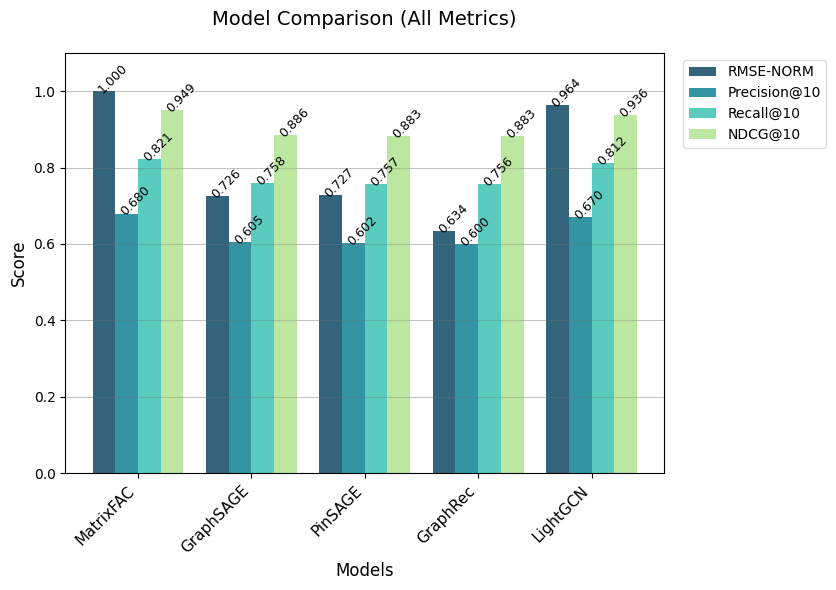

In [32]:
colors = ['#003D5B', '#00798C', '#30BEB0', '#ABE188']

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(models))
w = 0.2

# Plot bars with soft pastel colors and subtle edge
bars1 = ax.bar(x - 1.5*w, rmse_norm, w, label='RMSE-NORM', color=colors[0], alpha=0.8)
bars2 = ax.bar(x - 0.5*w, precision, w, label='Precision@10', color=colors[1], alpha=0.8)
bars3 = ax.bar(x + 0.5*w, recall, w, label='Recall@10', color=colors[2], alpha=0.8)
bars4 = ax.bar(x + 1.5*w, ndcg, w, label='NDCG@10', color=colors[3], alpha=0.8)

# Add value labels with reduced boldness
def add_value_labels(bars, values):
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() + 0.02, height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='normal',
                rotation=45, rotation_mode='anchor'
                )

add_value_labels(bars1, rmse_norm)   # Show actual RMSE
add_value_labels(bars2, precision)
add_value_labels(bars3, recall)
add_value_labels(bars4, ndcg)

# Style the plot with reduced font boldness
ax.set_title('Model Comparison (All Metrics)', fontsize=14, fontweight='normal', pad=20)
ax.set_xlabel('Models', fontsize=12, fontweight='normal')
ax.set_ylabel('Score', fontsize=12, fontweight='normal')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=11, fontweight='normal')
ax.grid(axis='y', alpha=0.3, linestyle='-', color='gray')
ax.set_ylim(0, 1.10)

# Set background to white
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Add legend on the right
legend = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, frameon=True, 
                   title_fontsize=10, prop={'weight': 'normal'})
legend.get_frame().set_edgecolor('lightgray')
legend.get_frame().set_linewidth(1)

# Add subtle horizontal lines
for y in ax.get_yticks():
    ax.axhline(y=y, color='lightgray', linestyle='-', linewidth=0.5, zorder=0)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('../docs/eval_stack.png', dpi=300)
plt.show()

In [33]:
# [1, 6, 31, 40, 53] 

# 'mf', 'lightgcn', 'graphsage', 'pinsage', 'graphrec'

In [56]:
class MovieRecommendationSystem:
    """
    Comprehensive movie recommendation system with all models
    """
    
    def __init__(self):
        """Initialize the recommendation system"""
        pass
    
    def get_movie_info(self, movie_id):
        """
        Get detailed information about a specific movie
        """
        movie_row = movies[movies['movieId'] == movie_id]
        if len(movie_row) > 0:
            return {
                'movie_id': movie_row.iloc[0]['movieId'],
                'title': movie_row.iloc[0]['title'],
                'genres': movie_row.iloc[0]['genres']
            }
        return None
    
    def _validate_user(self, user_id):
        """
        Validate if user exists in training data
        """
        return user_id in user_mapping
    
    def _load_model(self, model_name):
        """
        Load a specific model from saved file
        """
        if model_name == 'mf':
            model = MatrixFactorization(num_users, num_movies, embed_dim=64)
            model.load_state_dict(torch.load('../models/best_mf_model.pth', weights_only=True))
        elif model_name == 'lightgcn':
            model = LightGCN_Rating(num_users, num_movies, embed_dim=64, num_layers=3)
            model.load_state_dict(torch.load('../models/best_rating_lightgcn_model.pth', weights_only=True))
        elif model_name == 'graphsage':
            model = GraphSAGE_Recommender(input_dim=data.x.shape[1], dropout_rate=0.3)
            model.load_state_dict(torch.load('../models/best_graphsage_model.pth', weights_only=True))
        elif model_name == 'pinsage':
            model = SimplePinSAGE(input_dim=data.x.shape[1], dropout_rate=0.3)
            model.load_state_dict(torch.load('../models/best_simple_pinsage_model.pth', weights_only=True))
        elif model_name == 'graphrec':
            # Fixed: Use correct GraphRec initialization without output_dim
            model = GraphRec(input_dim=data.x.shape[1], hidden_dim=64)
            model.load_state_dict(torch.load('../models/best_graphrec_model.pth', weights_only=True))
        else:
            raise ValueError(f"Unknown model: {model_name}")
        
        model.eval()
        return model
    
    def recommend_for_user(self, user_id, model_name='mf', n_recommendations=10):
        """
        Get personalized movie recommendations for a user using specified model
        """
        # Validate user
        if not self._validate_user(user_id):
            print(f" User {user_id} not found in training data")
            return []
        
        # Load model
        model = self._load_model(model_name)
        
        # Get recommendations based on model type
        user_idx = user_mapping[user_id]
        
        with torch.no_grad():
            if model_name == 'mf':
                all_movie_indices = torch.arange(num_movies)
                pred = model(torch.tensor([user_idx]).repeat(num_movies), all_movie_indices)
            elif model_name == 'lightgcn':
                all_movie_indices = torch.arange(num_movies)
                # Fixed: LightGCN uses movie indices without offset for rating prediction
                pred = model(edge_index_proper, 
                            torch.tensor([user_idx]).repeat(num_movies), 
                            all_movie_indices)
            elif model_name in ['graphsage', 'pinsage']:
                all_movie_indices = torch.arange(num_movies) + num_users
                pred = model(data.x, data.edge_index, 
                            torch.tensor([user_idx]).repeat(num_movies), all_movie_indices)
            elif model_name == 'graphrec':
                all_movie_indices = torch.arange(num_movies)
                pred = model(data.x, data.edge_index, 
                            torch.tensor([user_idx]).repeat(num_movies), all_movie_indices)
        
        top_scores, top_movie_indices = torch.topk(pred, n_recommendations)
        
        recommendations = []
        for score, movie_idx_tensor in zip(top_scores, top_movie_indices):
            original_movie_id = list(movie_mapping.keys())[movie_idx_tensor.item()]
            movie_info = self.get_movie_info(original_movie_id)
            if movie_info:
                recommendations.append((original_movie_id, movie_info['title'], score.item()))
        
        return recommendations

In [57]:
recommender = MovieRecommendationSystem()

print("=== MODEL COMPARISON ===")
models_to_test = ['mf', 'lightgcn', 'graphsage', 'pinsage', 'graphrec']

for model_name in models_to_test:
    try:
        recommendations = recommender.recommend_for_user(user_id=53, model_name=model_name, n_recommendations=5)
        print(f"\n{model_name.upper()}:")
        for movie_id, title, rating in recommendations:
            print(f"  {title} (Rating: {rating:.3f})")
    except Exception as e:
        print(f"{model_name.upper()}: Error - {str(e)}")

=== MODEL COMPARISON ===

MF:
  Twin Peaks (1989) (Rating: 4.491)
  Godfather: Part II, The (1974) (Rating: 4.469)
  Underground (1995) (Rating: 4.439)
  Godfather, The (1972) (Rating: 4.427)
  One Flew Over the Cuckoo's Nest (1975) (Rating: 4.416)

LIGHTGCN:
  Band of Brothers (2001) (Rating: 4.490)
  Planet Earth (2006) (Rating: 4.489)
  Planet Earth II (2016) (Rating: 4.485)
  Shawshank Redemption, The (1994) (Rating: 4.482)
  Blue Planet II (2017) (Rating: 4.417)

GRAPHSAGE:
  Midsommar (2019) (Rating: 4.003)
  American Gigolo (1980) (Rating: 3.905)
  Final Destination 5 (2011) (Rating: 3.873)
  Contact (1997) (Rating: 3.838)
  Red Corner (1997) (Rating: 3.838)

PINSAGE:
  Kingpin (1996) (Rating: 3.828)
  The Hunger Games: Catching Fire (2013) (Rating: 3.770)
  Dolce Vita, La (1960) (Rating: 3.756)
  Peeping Tom (1960) (Rating: 3.733)
  28 Days (2000) (Rating: 3.729)

GRAPHREC:
  Headhunters (Hodejegerne) (2011) (Rating: 4.219)
  Musketeer, The (2001) (Rating: 3.502)
  Desperately 